# Training

## 1. Loading datasets

### 1.1 Loading datasetst as `pandas DataFrame`

In [6]:
import pandas as pd

train_df = pd.read_csv("/root/train.csv", on_bad_lines='warn')
test_df = pd.read_csv("/root/test.csv")
test_labels_df = pd.read_csv("/root/test_labels.csv")

train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### 1.2 Class distribution visualization

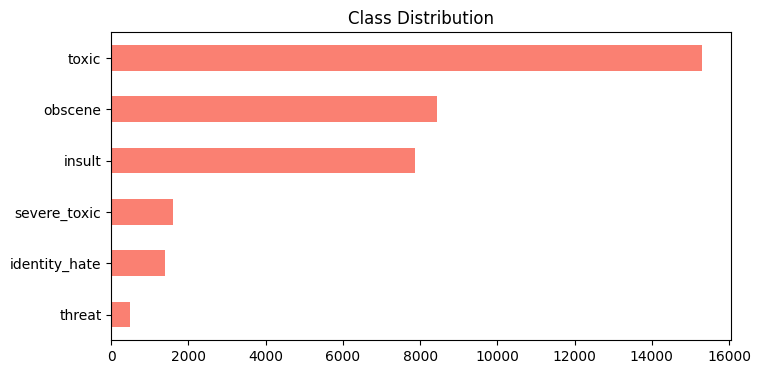

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of labels for classification
labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

plt.figure(figsize=(8,4))
train_df[labels].sum().sort_values().plot(kind='barh', color='salmon')
plt.title("Class Distribution")
plt.show()

## 2. Preparing the dataset

### 2.1 Multilabel Stratified Splitting for handling the class imbalance

In [13]:

pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 182.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Using `MultilabelStratifiedKFold`

In [9]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# X is the input (we only need index here)
X = train_df.index.values
# y is the multi-hot encoded label matrix
y = train_df[labels].values
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [10]:
mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_index, val_index in mskf.split(X, y):
  train_split = train_df.iloc[train_index]
  val_split = train_df.iloc[val_index]
  break

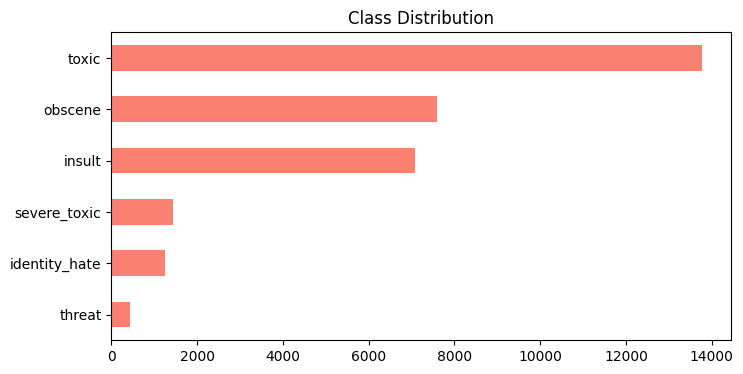

In [11]:
plt.figure(figsize=(8,4))
train_split[labels].sum().sort_values().plot(kind='barh', color='salmon')
plt.title("Class Distribution")
plt.show()

In [12]:
train_split[labels].sum()

toxic            13765
severe_toxic      1435
obscene           7605
threat             430
insult            7089
identity_hate     1264
dtype: int64

### 2.2 Converting to Hugging Face dataset format

In [14]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Converting to HF dataset
train_dataset = Dataset.from_pandas(train_split.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_split.reset_index(drop=True))

train_dataset

Dataset({
    features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
    num_rows: 143614
})

In [15]:
# Wrapping into a Dataset Dict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 143614
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 15957
    })
})

tensor([  9.4333,  99.0794,  17.8842, 332.9861,  19.2587, 112.6187])

## 3. Tokenization

### 3.1 Load Tokenizer

In [49]:

from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### 3.2 Create a tokenization and encoding function


In [40]:
# Token and Encode Function
def preprocess_function(examples):
    # Tokenize
    tokenized = tokenizer(
        examples["comment_text"],
        truncation=True,
        max_length=128
    )

    # Attach multilabel targets as floats
    tokenized["labels"] = [
        [float(examples[label][i]) for label in labels]
        for i in range(len(examples["comment_text"]))
    ]
    return tokenized


### 3.3 Tokenization/Preprocessing

In [41]:
# tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

tokenized_dataset

Map:   0%|          | 0/143614 [00:00<?, ? examples/s]

Map:   0%|          | 0/15957 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 143614
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15957
    })
})


Checking how many examples have all labels zero (non-toxic comments)


In [42]:

def all_zero(example):
    return all(label == 0 for label in example["labels"])

# Count how many match the conditio
num_all_zero = tokenized_dataset.filter(all_zero).num_rows
print(f"Examples with all 0 labels: {num_all_zero} out of {tokenized_dataset.num_rows}")

Filter:   0%|          | 0/143614 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15957 [00:00<?, ? examples/s]

Examples with all 0 labels: {'train': 129015, 'validation': 14331} out of {'train': 143614, 'validation': 15957}


## 4. Fine-Tuning

### 4.1 Load model

In [50]:

from transformers import AutoModelForSequenceClassification

def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    problem_type='multi_label_classification'
    )

### 4.4 Dynamic Padding

In [44]:

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.4 Defining Metrics Function

In [78]:
# Setup compute_metrics function
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, roc_auc_score
import numpy as np

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid for multilabel
    preds = (probs >= 0.4).astype(int)
    labels = labels.astype(int)


    results = {
        "macro_f1": f1_score(labels, preds, average='macro'),
        "micro_f1": f1_score(labels, preds, average='micro'),
        "precision": precision_score(labels, preds, average='macro', zero_division=0),
        "recall": recall_score(labels, preds, average='macro', zero_division=0),
        "hamming_loss": hamming_loss(labels, preds),
    }

    # Add ROC AUC
    try:
        results["roc_auc_macro"] = roc_auc_score(labels, probs, average='macro')
        results["roc_auc_micro"] = roc_auc_score(labels, probs, average='micro')
    except ValueError:
        # Handle case where some classes have no positive samples
        results["roc_auc_macro"] = 0.0
        results["roc_auc_micro"] = 0.0

    return results

    


### 4.6 Training Arguments + Trainer

In [55]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./checkpoints-toxic",
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",   # <-- Save every epoch
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    save_total_limit=2,
    disable_tqdm=False                      # Show progress bar
)


trainer = Trainer(
    model = None,
    model_init = model_init,
    processing_class=tokenizer,
    args = training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.05), 
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64]),
    }

best_trials = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20,
)


[I 2025-12-01 04:49:12,686] A new study created in memory with name: no-name-8ac7ab5f-3c7e-4ad9-b6a9-9f8910f9e870
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.066100,0.057197,0.383623,0.732921,0.539371,0.392402,0.018947,0.954605,0.983487,9.386400,1700.014000,212.542000
2,0.050800,0.048912,0.462581,0.751286,0.473799,0.463947,0.018174,0.967119,0.986127,9.383600,1700.512000,212.604000
3,0.046700,0.047537,0.461332,0.751342,0.469396,0.466482,0.018383,0.972909,0.987057,9.385800,1700.126000,212.556000


[I 2025-12-01 04:52:10,008] Trial 0 finished with value: 4.126901068728941 and parameters: {'learning_rate': 1.8874000584711368e-06, 'weight_decay': 0.009722648146874353, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 4.126901068728941.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.043200,0.040316,0.552741,0.783534,0.605579,0.538594,0.015928,0.986093,0.990987,9.409700,1695.798000,212.015000
2,0.036300,0.038699,0.638498,0.786532,0.704048,0.643060,0.016356,0.988646,0.992115,9.385800,1700.122000,212.555000
3,0.034800,0.038546,0.659303,0.789308,0.684119,0.664764,0.016054,0.989264,0.992254,9.410400,1695.672000,211.999000


[I 2025-12-01 04:56:14,244] Trial 1 finished with value: 4.79506443224434 and parameters: {'learning_rate': 7.849932650648995e-06, 'weight_decay': 0.04717762016773064, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 4.79506443224434.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.041100,0.039859,0.627863,0.783907,0.729352,0.621734,0.015876,0.989236,0.991244,9.361100,1704.611000,213.116000
2,0.032700,0.038669,0.678078,0.793264,0.668397,0.693119,0.015772,0.989432,0.992428,9.354300,1705.846000,213.271000
3,0.022900,0.042353,0.693279,0.789409,0.665267,0.723916,0.016200,0.989653,0.991826,9.366400,1703.650000,212.996000


[I 2025-12-01 04:59:11,534] Trial 2 finished with value: 4.869551319825188 and parameters: {'learning_rate': 6.085614532354611e-05, 'weight_decay': 0.009601567168274478, 'per_device_train_batch_size': 64}. Best is trial 2 with value: 4.869551319825188.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.040200,0.038521,0.642717,0.788874,0.703890,0.615613,0.015302,0.989544,0.992163,9.363100,1704.252000,213.072000
2,0.034100,0.037976,0.689361,0.792891,0.690878,0.697662,0.015824,0.989388,0.992791,9.381000,1700.996000,212.664000
3,0.026600,0.041307,0.686646,0.789445,0.662233,0.714010,0.016168,0.989816,0.992125,9.379200,1701.313000,212.704000


[I 2025-12-01 05:06:07,730] Trial 3 finished with value: 4.85044312988956 and parameters: {'learning_rate': 1.5059319721294715e-05, 'weight_decay': 0.0453724579857859, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 4.869551319825188.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.042700,0.040639,0.540007,0.783221,0.632370,0.513616,0.015761,0.985703,0.990779,9.417300,1694.431000,211.844000
2,0.038600,0.038747,0.640623,0.789173,0.716240,0.633078,0.015782,0.988491,0.992058,9.410700,1695.614000,211.992000
3,0.034200,0.039113,0.656728,0.790096,0.680980,0.658880,0.015939,0.989137,0.992152,9.390800,1699.214000,212.442000


[I 2025-12-01 05:12:57,874] Trial 4 finished with value: 4.783911032523835 and parameters: {'learning_rate': 4.941008729034475e-06, 'weight_decay': 0.012753701749347464, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 4.869551319825188.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.040900,0.038186,0.650862,0.789630,0.681832,0.635149,0.015510,0.989858,0.992245,9.343100,1707.900000,213.528000
2,0.032100,0.037932,0.667627,0.791474,0.653989,0.691151,0.016043,0.990150,0.992731,9.361300,1704.579000,213.112000
3,0.027800,0.040060,0.684306,0.790717,0.653381,0.718775,0.016106,0.990088,0.992306,9.395000,1698.459000,212.347000


[I 2025-12-01 05:16:57,122] Trial 5 finished with value: 4.845678790044905 and parameters: {'learning_rate': 1.9784027224597626e-05, 'weight_decay': 0.03249170202920507, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 4.869551319825188.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.042800,0.040769,0.535714,0.781411,0.628934,0.510526,0.015918,0.985543,0.990715,9.404100,1696.813000,212.142000


[I 2025-12-01 05:19:12,484] Trial 6 pruned. 
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.042200,0.039394,0.572106,0.785663,0.589277,0.561615,0.015740,0.987542,0.991461,9.375300,1702.032000,212.794000


[I 2025-12-01 05:20:31,557] Trial 7 pruned. 
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.048000,0.045624,0.458449,0.755978,0.483248,0.453333,0.017693,0.979485,0.988260,9.383200,1700.587000,212.613000


[I 2025-12-01 05:21:50,530] Trial 8 pruned. 
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.046300,0.043736,0.470537,0.764865,0.474576,0.473613,0.017223,0.981779,0.989429,9.397100,1698.068000,212.298000


[I 2025-12-01 05:22:48,858] Trial 9 pruned. 
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.041800,0.040244,0.609538,0.781197,0.704265,0.610106,0.016189,0.988644,0.991209,9.411100,1695.555000,211.984000
2,0.033000,0.039068,0.667939,0.788806,0.666846,0.676075,0.016001,0.988495,0.992155,9.411000,1695.573000,211.987000
3,0.023100,0.042681,0.678418,0.784533,0.649238,0.710600,0.016471,0.988831,0.991664,9.403900,1696.841000,212.145000


[I 2025-12-01 05:25:47,449] Trial 10 finished with value: 4.819754322304119 and parameters: {'learning_rate': 7.633277296702147e-05, 'weight_decay': 0.0007673031071856115, 'per_device_train_batch_size': 64}. Best is trial 2 with value: 4.869551319825188.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.043900,0.042228,0.561022,0.765029,0.689161,0.550919,0.016983,0.984288,0.989473,9.423600,1693.302000,211.703000


[I 2025-12-01 05:28:04,374] Trial 11 pruned. 
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.040100,0.038471,0.650187,0.787079,0.689131,0.643652,0.015834,0.990146,0.992098,9.405600,1696.551000,212.109000
2,0.033100,0.038016,0.686811,0.793434,0.675432,0.708705,0.015772,0.990118,0.992604,9.412300,1695.337000,211.957000
3,0.025400,0.040310,0.694843,0.789814,0.660623,0.734275,0.016294,0.990182,0.992177,9.436000,1691.082000,211.425000


[I 2025-12-01 05:31:01,684] Trial 12 finished with value: 4.878207175126608 and parameters: {'learning_rate': 3.2719182895564304e-05, 'weight_decay': 0.023377366840031614, 'per_device_train_batch_size': 64}. Best is trial 12 with value: 4.878207175126608.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.040100,0.038702,0.651680,0.787033,0.690292,0.643210,0.015782,0.990065,0.991942,9.463100,1686.230000,210.818000
2,0.032900,0.038153,0.679340,0.793038,0.665213,0.704091,0.015897,0.990116,0.992508,9.450900,1688.411000,211.091000
3,0.024700,0.040796,0.690303,0.790805,0.659580,0.725784,0.016158,0.990180,0.991923,9.481800,1682.903000,210.402000


[I 2025-12-01 05:33:59,829] Trial 13 finished with value: 4.864732665767061 and parameters: {'learning_rate': 3.7633635970161574e-05, 'weight_decay': 0.022577078902577735, 'per_device_train_batch_size': 64}. Best is trial 12 with value: 4.878207175126608.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.040000,0.038570,0.650089,0.786495,0.684579,0.643142,0.015918,0.989963,0.992001,9.447500,1689.011000,211.166000
2,0.032900,0.038178,0.677583,0.791170,0.674222,0.695004,0.015907,0.990185,0.992552,9.437000,1690.889000,211.401000
3,0.025000,0.040538,0.689374,0.788638,0.657388,0.726514,0.016398,0.990393,0.992137,9.425800,1692.906000,211.653000


[I 2025-12-01 05:36:57,381] Trial 14 pruned. 
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.040200,0.038740,0.656813,0.786479,0.682206,0.650647,0.016033,0.989924,0.991969,9.462100,1686.420000,210.842000
2,0.032700,0.038349,0.682263,0.792463,0.676987,0.701689,0.015876,0.990217,0.992460,9.428000,1692.507000,211.603000
3,0.024800,0.040599,0.685880,0.789886,0.656931,0.719597,0.016231,0.990455,0.992074,9.434300,1691.381000,211.462000


[I 2025-12-01 05:39:55,265] Trial 15 pruned. 
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.042500,0.042042,0.601303,0.776404,0.724430,0.591420,0.016430,0.985312,0.989052,9.453600,1687.928000,211.031000


[I 2025-12-01 05:40:54,619] Trial 16 pruned. 
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.107300,0.085163,0.362587,0.692653,0.388237,0.341580,0.020012,0.930303,0.973856,9.482100,1682.855000,210.396000


[I 2025-12-01 05:41:53,703] Trial 17 pruned. 
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.041300,0.039224,0.579659,0.786733,0.589989,0.574396,0.015782,0.987356,0.991501,9.437000,1690.894000,211.402000


[I 2025-12-01 05:42:52,178] Trial 18 pruned. 
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.040700,0.039174,0.639247,0.786945,0.688481,0.640583,0.015886,0.989512,0.991524,9.450700,1688.453000,211.096000


[I 2025-12-01 05:43:50,773] Trial 19 pruned. 


### 4.6 Train

In [60]:
best_trial = best_trials  # returned from hyperparameter_search
best_params = best_trial.hyperparameters
print(best_params)


{'learning_rate': 3.2719182895564304e-05, 'weight_decay': 0.023377366840031614, 'per_device_train_batch_size': 64}


In [61]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./checkpoints-toxic",
    fp16=True,
    report_to="none",
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="macro_f1",
    load_best_model_at_end=True,
    save_total_limit=2,
    disable_tqdm=False,
    
    # Updated from best trial
    learning_rate=best_params["learning_rate"],
    weight_decay=best_params["weight_decay"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],

    num_train_epochs=5,
    )

trainer = Trainer(
    model=None,
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)



Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.040200,0.038692,0.647259,0.784970,0.680589,0.642712,0.015960,0.990085,0.991969,9.345600,1707.437000,213.470000
2,0.033600,0.038525,0.679827,0.791158,0.672703,0.697391,0.016085,0.989798,0.992388,9.329200,1710.430000,213.844000
3,0.025900,0.041382,0.689571,0.787217,0.652036,0.735972,0.016482,0.989978,0.991794,9.311800,1713.637000,214.245000
4,0.019900,0.046325,0.676133,0.785219,0.652467,0.704130,0.016513,0.988693,0.990493,9.312900,1713.429000,214.219000
5,0.015100,0.051018,0.696948,0.785763,0.667214,0.729777,0.016346,0.988467,0.990042,9.340800,1708.310000,213.579000


TrainOutput(global_step=11220, training_loss=0.029234252617745902, metrics={'train_runtime': 294.4591, 'train_samples_per_second': 2438.607, 'train_steps_per_second': 38.104, 'total_flos': 2.378191258381824e+16, 'train_loss': 0.029234252617745902, 'epoch': 5.0})

In [63]:

trainer.save_model("./best-toxic-model")

## 5. Saving Model and Tokenizer

In [64]:

from huggingface_hub import login

login()

In [65]:

trainer.push_to_hub()

It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...0/checkpoint-4488/model.safetensors:   1%|1         | 3.79MB /  268MB            

  ...0/checkpoint-6732/model.safetensors:   1%|1         | 3.73MB /  268MB            

  .../run-0/checkpoint-4488/optimizer.pt:   0%|          |  604kB /  536MB            

  .../run-0/checkpoint-6732/optimizer.pt:   0%|          |  572kB /  536MB            

  ...run-1/checkpoint-13464/optimizer.pt:   0%|          |  613kB /  536MB            

  ...ic/run-1/checkpoint-13464/scaler.pt: 100%|##########| 1.38kB / 1.38kB            

  ...checkpoints-toxic/model.safetensors:   0%|          |  574kB /  268MB            

  .../checkpoint-13464/model.safetensors:   0%|          |  573kB /  268MB            

  ...xic/run-1/checkpoint-8976/scaler.pt: 100%|##########| 1.38kB / 1.38kB            

  ...1/checkpoint-8976/model.safetensors:   2%|1         | 4.02MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/dipeshpandit/checkpoints-toxic/commit/8bc1def85e02de491790a7e3089e724500d63be1', commit_message='End of training', commit_description='', oid='8bc1def85e02de491790a7e3089e724500d63be1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dipeshpandit/checkpoints-toxic', endpoint='https://huggingface.co', repo_type='model', repo_id='dipeshpandit/checkpoints-toxic'), pr_revision=None, pr_num=None)

# Model Evaluation

### Test data preprocessing

In [66]:

from datasets import Dataset

test_dataset = Dataset.from_pandas(test_df)


In [67]:

import numpy as np

# Add labels to test_dataset
test_labels = test_labels_df[labels].values.astype(np.float32)
test_dataset = test_dataset.add_column('labels', test_labels.tolist())
test_dataset[2]

{'id': '00013b17ad220c46',
 'comment_text': '" \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "',
 'labels': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}

Let's check how many examples are unlabelled as

``` labels: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0] ```

In [68]:
def all_neg1(example):
    return all(label == -1 for label in example["labels"])

# Count how many match the conditio
num_all_neg1 = test_dataset.filter(all_neg1).num_rows
print(f"Examples with all -1 labels: {num_all_neg1} out of {test_dataset.num_rows}")

Filter:   0%|          | 0/153164 [00:00<?, ? examples/s]

Examples with all -1 labels: 89186 out of 153164


In [69]:
# Remove the examples having all -1 labels
def has_valid_labels(example):
    return any(label != -1 for label in example["labels"])

test_dataset = test_dataset.filter(has_valid_labels)
test_dataset[2]

Filter:   0%|          | 0/153164 [00:00<?, ? examples/s]

{'id': '0002f87b16116a7f',
 'comment_text': '"::: Somebody will invariably try to add Religion?  Really??  You mean, the way people have invariably kept adding ""Religion"" to the Samuel Beckett infobox?  And why do you bother bringing up the long-dead completely non-existent ""Influences"" issue?  You\'re just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories!    \n\n "',
 'labels': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [70]:

def tokenize_function(examples):
    return tokenizer(examples['comment_text'], truncation=True, max_length=128)

In [71]:

test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/63978 [00:00<?, ? examples/s]

## 1. Per Label Threshold Analysis

In [72]:

import numpy as np
from sklearn.metrics import f1_score

def find_optimal_thresholds(y_true, y_probs, step=0.01):
    """
    Finds the best threshold per label to maximize F1 score.

    Args:
        y_true: np.array of shape (n_samples, n_labels)
        y_probs: np.array of shape (n_samples, n_labels) - model output after sigmoid
        step: float - step size for threshold search

    Returns:
        thresholds: list of optimal threshold per label
    """
    n_labels = y_true.shape[1]
    thresholds = []

    for i in range(n_labels):
        best_thresh = 0.5
        best_f1 = 0.0
        for t in np.arange(0.1, 0.9 + step, step):
            preds = (y_probs[:, i] >= t).astype(int)
            f1 = f1_score(y_true[:, i], preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t
        thresholds.append(best_thresh)
        print(f"Label {i}: Best threshold = {best_thresh:.2f} | F1 = {best_f1:.4f}")

    return thresholds


In [73]:

import torch

# y_probs: logits from model output, apply sigmoid
logits = trainer.predict(tokenized_dataset["validation"]).predictions
y_probs = torch.sigmoid(torch.tensor(logits)).numpy()

# y_true: ground truth multilabels (should be 0/1 matrix)
y_true = tokenized_dataset["validation"]["labels"]
y_true = np.array(y_true)

# Find optimal thresholds
optimal_thresholds = find_optimal_thresholds(y_true, y_probs)


Label 0: Best threshold = 0.57 | F1 = 0.8312
Label 1: Best threshold = 0.30 | F1 = 0.5564
Label 2: Best threshold = 0.49 | F1 = 0.8383
Label 3: Best threshold = 0.39 | F1 = 0.6275
Label 4: Best threshold = 0.36 | F1 = 0.7636
Label 5: Best threshold = 0.37 | F1 = 0.6179


In [79]:

import json

with open("optimal_thresholds.json", "w") as f:
    json.dump(optimal_thresholds, f)


In [80]:

opt_thresholds = np.array([0.57, 0.30, 0.49, 0.39, 0.36, 0.37])

## 2. Model Performance

### Setup compute metrics function with optimal thresholds per label

In [82]:

from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    # Use global optimal_thresholds defined outside the function
    preds = (probs >= opt_thresholds).astype(int)

    return {
        "f1_micro": f1_score(labels, preds, average="micro"),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_micro": precision_score(labels, preds, average="micro"),
        "recall_micro": recall_score(labels, preds, average="micro"),
        "precision_macro": precision_score(labels, preds, average="macro"),
        "recall_macro": recall_score(labels, preds, average="macro"),
    }


In [83]:
# Then evaluate
test_results = trainer.predict(test_dataset)
test_metrics = compute_metrics((test_results.predictions, test_results.label_ids))

for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

f1_micro: 0.6668
f1_macro: 0.6083
precision_micro: 0.5642
recall_micro: 0.8152
precision_macro: 0.5264
recall_macro: 0.7475
